In [1]:
from platform import python_version
print(python_version())

3.7.9


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad,dblquad,nquad
from scipy.special import comb
from scipy.optimize import minimize_scalar, minimize, newton, differential_evolution
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
#import multiprocessing as mp
from copy import deepcopy
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import cycler
prop_cycle = plt.rcParams['axes.prop_cycle']
DEFAULT_COLORS = prop_cycle.by_key()['color']
plt.rc('text', usetex=True)
plt.rc('font', **{'size':10})
DEFCOLS = prop_cycle.by_key()['color']

#################################################################
# Framework potential object
#################################################################

In [3]:
class FrameworkPotential(object):
    def __init__(self,params):
        self.params = params
    
class DoubleWellRotate(FrameworkPotential):
    def __init__(self,params):
        super(DoubleWellRotate,self).__init__(params)
        
        if params == None:
            self.set_default_init_params()
        else:
            self.set_params(params)
            
    def set_default_init_params(self):
        self.Vmax = 10000
        self.a = np.pi/4
        self.b = np.pi/8
        self.c = 10000
        self.params = [self.Vmax, self.a, self.b, self.c]
    
    def set_params(self,params):
        self.params = params  
        self.Vmax = params[0]
        self.a = params[1]
        self.b = params[2]
        self.c = params[3]
        
    def compute_energy(self,theta):
        return self.Vmax/self.b**4*((theta-self.a/2)**2-self.b**2)**2-self.c*theta

    def compute_minima_hi(self):
        thetamin = minimize(self.compute_energy,[10]).x[0]
        return thetamin
    
class DoubleWellRotateVibrate(DoubleWellRotate):
    def __init__(self,params):
        super(DoubleWellRotateVibrate,self).__init__(params)
        
    def set_params(self,params):
        self.Vmax = params[0]
        self.a = params[1]
        self.b = params[2]
        self.c = params[3]
        self.k = params[4]
        self.Leq = params[5]
          
    def compute_energy(self,theta,L):
        return super().compute_energy(theta)+self.k/2*(L-self.Leq)**2
      

#################################################################
# Flexible slit pore object
#################################################################

In [4]:
class RotatingSlitPore(object):
    
    def __init__(self,EFGparams={'epsG':148,'epsF':52.8,'sigG':3.73,
                                 'sigF':3.43,'ds':0.382},
                      GEOMparams={'L':None},
                      EFparams={'name':"24DoubleWell",'params':None},
                      SIMparams={'T':298, 'R':8.31441},
                      Nmax=4,
                      verbose=True,
                      Qcalculate=True):
        
        # simulation properties
        self.T = SIMparams['T']
        self.R = SIMparams['R']
        self.beta = 1/(self.R*self.T)
        
        # framework-guest parameters
        # eps between UFF carbon and TRAPPE methane, J/mol [=] K * J/molK 
        self.eps = np.sqrt(EFGparams['epsG']*EFGparams['epsF']) * self.R 
        # sig between UFF carbon and TRAPPE methane
        self.sig = (EFGparams['sigG']+EFGparams['sigF'])/2 
        # atoms/A^2 in graphene
        self.ds = EFGparams['ds'] 
        # saturation loading+1
        self.Nmax = Nmax 
        
        # slit pore properties
        if GEOMparams['L'] is None:
            rmin, Umin = self.get_rmin_Umin()
            self.rmin = rmin
            self.L = 2*rmin
            self.Umin = 2*Umin
        else:
            self.L = GEOMparams['L']
            self.Umin = None
            self.rmin = None
        
        # framework geometry/parameters
        self.efname = EFparams['name']

        if self.efname == "DoubleWellStatic":
            self.efinstance = DoubleWellRotate(EFparams['params'])
            self.Qmethod = self.computeQN_Static
        elif self.efname == "DoubleWellRotate":
            self.efinstance = DoubleWellRotate(EFparams['params'])
            self.Qmethod = self.computeQN_ThetaFlex
        elif self.efname == "DoubleWellRotateVibrate":
            self.efinstance = DoubleWellRotateVibrate(EFparams['params']+[self.L])
            self.Qmethod = self.computeQN_ThetaFlex_LFlex
        else:
            # no definition for ef
            raise ValueError("No known definition for EF")
        setattr(self,'computeEF',getattr(self.efinstance,'compute_energy')) 
         
        if verbose:
            print("Adsorption properties:")
            print("eps:",self.eps)
            print("sig:",self.sig)
            print("ds:",self.ds)
            print("Nmax:", self.Nmax)
            print("rmin, Umin (min possible binding U):", 
                  self.rmin, self.Umin)

            print("Slit pore properties:")
            print("L:",self.L)

            print("Framework properties:")
            print("params:", self.efinstance.params)
            
            print("Computing all Q(N) up to Nmax...")
        
        if Qcalculate:
            self.computeAllQ(verbose)
    
    def computeAllQ(self,verbose,**kwargs):
        # compute only once for a given geometry/energy scheme
        for N in range(self.Nmax+1):
            start=time.time()
            integral = self.Qmethod(N,**kwargs)
            end=time.time()
            if verbose:
                print("Computed Q%d in %.1fs"%(N,end-start))
                print("Integral, uncertainty, Q:",
                      integral,getattr(self,"Q%d"%N))

    def get_rmin_Umin(self):
        rmin = minimize_scalar(self.computeLJ,bounds=(0.5,12),
                               method='bounded').x
        return rmin, 2*self.computeLJ(rmin)
        
    def computeRw(self,r,theta):
        # theta in rads
        return r*np.cos(theta)
    
    def computeLJn(self,eps,sig,r):
        term = (sig/r)**6
        return 4*eps*(term**2-term)
    
    def computeLJ(self,r):
        return 2*np.pi*self.eps*self.sig**2*self.ds*(2/5*(self.sig/r)**10-(self.sig/r)**4)
    
    def computeEFG(self,r,theta,L):
        # theta in rads
        # Note that we compute two interactions, one for each wall
        # of the slitpore
        # accepts scaled coordinate s = r/d for ease of integration
        rw1 = r * np.cos(theta)
        rw2 = (L-r) * np.cos(theta)
        
        U = self.computeLJ(rw1) +\
            self.computeLJ(rw2)
        
        return U

    def computeQN_Static(self,N,theta=0):#31.4/360*2*np.pi):
        trunc = 0
        a1 = trunc
        b1 = self.L-trunc
        fullint = lambda r: np.exp(-self.beta*
                                   self.computeEFG(r,theta,self.L))
        integral = quad(fullint,a1,b1)
        # Q = (M choose N) * q^N
        Q = 1.1**N*comb(self.Nmax,N)*integral[0]**N
        setattr(self,'Q%d'%N, Q)
        
        return integral
    
    def computeQN_ThetaFlex(self,N):
        # https://stackoverflow.com/questions/43925780/nesting-numerical-integrals-in-python
        trunc = 0
        a1=-np.pi/4
        b1=np.pi/3
        def int2(theta):
            partial_func = lambda r: np.exp(-self.beta*self.computeEFG(r,theta,self.L))
            a2 = trunc
            b2 = self.L - trunc
            return quad(partial_func,a2,b2)[0]
        fullint = lambda theta: np.exp(-self.beta*self.computeEF(theta))*\
                                int2(theta)**N

        integral = quad(fullint,a1,b1)
        Q = 1.1**N*comb(self.Nmax,N)*integral[0]
        setattr(self,'Q%d'%N, Q)
        
        return integral
        
    def computeQN_ThetaFlex_LFlex(self,N):
        # https://stackoverflow.com/questions/43925780/nesting-numerical-integrals-in-python
        trunc = 0
        a1=-np.pi/4
        b1=np.pi/3
        a11=self.L-2
        b11=self.L+2
        def int2(theta,L):
            partial_func = lambda r: np.exp(-self.beta*self.computeEFG(r,theta,L))
            a2 = trunc
            b2 = L - trunc
            return quad(partial_func,a2,b2)[0]
        # lambda inner, outer: func
        fullint = lambda theta,L: np.exp(-self.beta*self.computeEF(theta,L))*int2(theta,L)**N

        integral = dblquad(fullint,a11,b11,a1,b1,epsrel=0.05)
        Q = 1.1**N*comb(self.Nmax,N)*integral[0]
        setattr(self,'Q%d'%N, Q)

        return integral
    
    def computeQN_ThetaFlex_LFlex_expectL(self,N):
        # https://stackoverflow.com/questions/43925780/nesting-numerical-integrals-in-python
        trunc = 0
        a1=-np.pi/4
        b1=np.pi/3
        a11=self.L-2
        b11=self.L+2
        def int2(theta,L):
            partial_func = lambda r: np.exp(-self.beta*self.computeEFG(r,theta,L))
            a2 = trunc
            b2 = L - trunc
            return quad(partial_func,a2,b2)[0]
        # lambda inner, outer: func
        fullint = lambda theta,L: L*np.exp(-self.beta*self.computeEF(theta,L))*int2(theta,L)**N
        normalize = lambda theta,L: np.exp(-self.beta*self.computeEF(theta,L))*int2(theta,L)**N

        # dblquad(func,outerlimit0,outerlimit1,innerlimit0,innerlimit1)
        integral1 = dblquad(fullint,a11,b11,a1,b1,epsrel=0.05)
        integral2 = dblquad(normalize,a11,b11,a1,b1,epsrel=0.05)

        return integral1[0]/integral2[0]
    
#     def multiproc_int_caller(self,func,num_processes):
#         #https://stackoverflow.com/questions/34291639/multiple-scipy-integrate-ode-instances
#         p = mp.Pool(num_processes)
#         p.map(func,[])
    
    def computeExpectN(self,P):
        
        # note accounts for the A = \int dydz = 4.19^2 term missing in the Q functions
        prefactor = 1e-30*6.02e23*P*self.beta
        
        Qs = [self.Q0]
        PIs = [self.Q0]
        for N in range(1,self.Nmax+1):
            Qs.append(getattr(self,'Q%d'%N))#**N)
            PIs.append((prefactor**N * getattr(self,'Q%d'%N)))

        Xi_P = np.sum(PIs)
        ExpectN = 1/(self.Nmax*Xi_P)*np.sum([N*PIs[N] for N in range(self.Nmax+1)])
        
        return ExpectN

    
    def computeIso(self,Plist):
        
        ExpectNList = [self.computeExpectN(P) for P in Plist]
                
        self.Plist = Plist
        self.ExpectNList = ExpectNList
        
        DCList = [self.computeExpectN(P) for P in [5.8e5,65e5]]
        DC = DCList[1]-DCList[0]
        
        return Plist, ExpectNList, DC
        
   
    def plotDebugEF(self):
        
        print("\n\nPlotting EF:")
        startr=2
        rlist = np.linspace(startr,self.L-startr,71)
        thetalist = np.linspace(-45*2*np.pi/360,60*2*np.pi/360,81)
        
        EFlist=np.array([self.computeEF(theta) for theta in thetalist])
        print("Min framework E: ",np.min(EFlist))
        fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True)
        ax[0].plot(thetalist*360/(2*np.pi),EFlist)
        ax[1].plot(thetalist*360/(2*np.pi),np.exp(-self.beta*EFlist))

        mindev = np.min(EFlist)+50000
        ax[0].set_ylim((np.min(EFlist),mindev))
        
        ax[0].set_xlabel("EF(theta)")
        ax[1].set_ylabel("exp(-B*EF(theta))")
        #ax[0].set_ylim((np.min(EFlist),0))
        plt.tight_layout()
        plt.show()

        
    def plotDebugEFG(self):
        
        print("\n\nPlotting EFG:")
        
        startr=2
        rlist = np.linspace(startr,self.L-startr,71)
        thetalist = np.linspace(-45*2*np.pi/360,60*2*np.pi/360,81)
        
        theta1=-30
        theta2=-10
        theta3=0
        EFGlist1 = np.array([self.computeEFG(r,theta1*2*np.pi/360,self.L) for r in rlist])
        EFGlist2 = np.array([self.computeEFG(r,theta2*2*np.pi/360,self.L) for r in rlist])
        EFGlist3 = np.array([self.computeEFG(r,theta3,self.L) for r in rlist])

        fig, ax = plt.subplots(nrows=2,ncols=1)

        print("Min binding E (BW): ", np.min(EFGlist1),
              np.exp(-self.beta*np.min(EFGlist1)))
        ax[0].plot(rlist, EFGlist1,
                   label="theta1=%.1f (Umin=%.1f)"%(theta1,np.min(EFGlist1)))
        print("Min binding E (BW): ", np.min(EFGlist2),
              np.exp(-self.beta*np.min(EFGlist2)))
        ax[0].plot(rlist, EFGlist2,
                   label="theta2=%.1f (Umin=%.1f)"%(theta2,np.min(EFGlist2)))
        print("Min binding E (BW): ", np.min(EFGlist3),
              np.exp(-self.beta*np.min(EFGlist3)))
        ax[0].plot(rlist, EFGlist3,
                   label="theta3=%.1f (Umin=%.1f)"%(theta3,np.min(EFGlist3)))
        ax[0].legend(loc='best')
        ax[0].set_xlabel('r (dist from cline)')
        ax[0].set_ylabel('EFG(r;theta)')
        ax[0].set_ylim((min(np.min(EFGlist1),np.min(EFGlist2),np.min(EFGlist3)),
                        max(np.min(EFGlist1),np.min(EFGlist2),np.min(EFGlist3))))
        
        ax[1].plot(rlist, np.exp(-self.beta*EFGlist1),label="theta1=%.1f"%theta1)
        ax[1].plot(rlist, np.exp(-self.beta*EFGlist2),label="theta2=%.1f"%theta2)
        ax[1].plot(rlist, np.exp(-self.beta*EFGlist3),label="theta3=%.1f"%theta3)
        ax[1].set_xlabel('r (dist from cline)')
        ax[1].set_ylabel('exp[-B*EFG(r;theta)]')   
        ax[1].legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,3.3))
        def addxy(x,y):
            return x+y
        EFGgrid = np.array([[self.computeEFG(r,theta,self.L) for theta in thetalist]
                             for r in rlist])
        EFGgridBW = np.exp(-self.beta*EFGgrid)
        im = ax[0].imshow(EFGgridBW, cmap='plasma', interpolation='nearest',origin='lower')
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        EFgrid = np.array([[self.computeEF(theta) for theta in thetalist]
                             for r in rlist])
        EFgridBW = np.exp(-self.beta*EFgrid)
        im = ax[1].imshow(EFgridBW, cmap='plasma', interpolation='nearest',origin='lower')
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ETOTgrid = EFGgrid + EFgrid
        ETOTgridBW = np.exp(-self.beta*ETOTgrid)
        im = ax[2].imshow(ETOTgridBW, cmap='plasma', interpolation='nearest',origin='lower')
        divider = make_axes_locatable(ax[2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical') 
        
        #plt.colorbar(im)
        #fig.savefig("error.pdf")
        plt.tight_layout()
        plt.show()
        
    def plotDebug(self):

        self.plotDebugEF()
        self.plotDebugEFG()
        self.plotEall()
       
    def plotEall(self):
        
        print("\n\nPlotting Eall:")
        
        thetalist = np.linspace(-45*2*np.pi/360,60*2*np.pi/360,100)
        thetaplotlist = np.linspace(-45,60,100)
        
        EFlist=np.array([self.computeEF(theta) for theta in thetalist])
        EFGlist=np.array([self.computeEFG(self.L/2,theta,self.L) for theta in thetalist])
        EFpEFGlist = EFlist+EFGlist
        print("Min framework E: ",np.min(EFlist))
        fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True)
        #plt.plot(thetas*360/(2*np.pi),Us)
        ax[0].plot(thetaplotlist,EFlist,label=r"$E_F$")
        ax[0].plot(thetaplotlist,EFGlist,label="$E_{FG}$")
        ax[0].plot(thetaplotlist,EFpEFGlist,label="$E_F+E_{FG}$")
        ax[0].legend(loc='best')
        
        minofmin = min(np.min(EFlist),np.min(EFGlist),np.min(EFpEFGlist))
        maxofmin = max(np.min(EFlist),np.min(EFGlist),np.min(EFpEFGlist))
        ax[0].set_ylim((minofmin,maxofmin+2*abs(maxofmin-minofmin)))
        ax[1].set_xlabel("Theta (deg)")
        
        ax[1].plot(thetaplotlist,np.exp(-self.beta*EFlist),label="EF")
        ax[1].plot(thetaplotlist,np.exp(-self.beta*EFGlist),label="EFG")
        ax[1].plot(thetaplotlist,np.exp(-self.beta*EFpEFGlist),label="Etot")
        ax[1].legend(loc='best') 
        
        plt.tight_layout()
        plt.show()


#################################################################
# Isotherm plotter
#################################################################

In [5]:
def plotIso(isolists,savename=None,special=None,speciallabel=None):

    if special is not None:
        n = len(isolists)
        color = plt.cm.plasma(np.linspace(0, 1, n))
        
        norm = matplotlib.colors.Normalize(vmin=min(special),
                                           vmax=max(special), clip=True)
        cmlist = matplotlib.cm.ScalarMappable(norm=norm,cmap='plasma')
        
        orig = deepcopy(matplotlib.rcParams['axes.prop_cycle'])
        matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(6.5,1.8),constrained_layout=True)#,
                               #gridspec_kw={'width_ratios':[0.2,3,3,3]})
    else:
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(7,2.2))


    for dat in isolists:
        series0 = ax[0].plot(dat[0]/100000,dat[1],**dat[3])

    ax[0].set_xlabel(r"$P\textrm{ [bar]}$")
    ax[0].set_ylabel(r"$\langle N \rangle / M$")
    ylim = ax[0].get_ylim()
    ax[0].plot([5.8,5.8],[ylim[0],ylim[1]],c='red',linestyle='--')
    ax[0].plot([65,65],[ylim[0],ylim[1]],c='red',linestyle='--')
    ax[0].set_ylim(ylim)
    
    if special is not None:
        #print(cmlist.to_rgba(list(Lspace)))
        DCs = [dat[2] for dat in isolists]
        ax[1].plot(special,DCs,c='black',linewidth=.5)
        series3 = ax[1].scatter(special,DCs,c=special,cmap='plasma_r')#c=[cmlist.to_rgba(elem) for elem in special])
        ax[1].set_xlabel(speciallabel)
        ax[1].set_ylabel(r"$DC\textrm{ [molec./site]}$")
        ax[1].set_ylim((None,1.0))
        ax[1].set_xlim((None,9.5))
        

        cbar = plt.colorbar(series3, orientation='vertical')
        cbar.set_label(speciallabel)#,x=y=1.05, rotation=0)
        
        matplotlib.rcParams['axes.prop_cycle'] = orig
    
    if savename is not None:
        plt.savefig(savename,transparent=True)
    plt.show()
    plt.close()

#################################################################
# Isotherm calculations
#################################################################

In [6]:
from multiprocessing import Pool
import itertools
import os

def compute_Static_isotherm(k,L,T=298,Plist = np.logspace(3,6.812913,100)):
    
    params = [20000,np.pi/6,np.pi/12,50000]
    model = RotatingSlitPore(EFparams={'name':'DoubleWellStatic',
                                       'params':list(params)},
                             GEOMparams={'L':L},
                             Nmax=1,
                             verbose=False,
                             SIMparams={'T':T, 'R':8.31441})
    
    P,N,DC = model.computeIso(Plist)
    return P,N,DC

def compute_Rotate_isotherm(k,L,T=298,Plist = np.logspace(3,6.812913,100)):
    
    params = [20000,np.pi/6,np.pi/12,50000]
    model = RotatingSlitPore(EFparams={'name':'DoubleWellRotate',
                                       'params':list(params)},
                             #EFGparams={'epsG':250,'epsF':52.8,'sigG':3.73,'sigF':3.43,'ds':0.382},
                             GEOMparams={'L':L},
                             Nmax=4,
                             verbose=False,
                             SIMparams={'T':T, 'R':8.31441})
    
    P,N,DC = model.computeIso(Plist)
    return P,N,DC

def compute_RotateVibrate_isotherm(k,L):
    params = [20000,np.pi/6,np.pi/12,50000,k]
    model = RotatingSlitPore(EFparams={'name':'DoubleWellRotateVibrate',
                                   'params':list(params)},
                             GEOMparams={'L':L},
                             Nmax=4,
                             verbose=False)

    Plist = np.logspace(3,6.812913,100)
    P,N,DC = model.computeIso(Plist)
    return P,N,DC

def compute_RotateVibrate_ExpectLSaturation(k,L):
    params = [20000,np.pi/6,np.pi/12,50000,k]
    model = RotatingSlitPore(EFparams={'name':'DoubleWellRotateVibrate',
                                   'params':list(params)},
                             GEOMparams={'L':L},
                             Nmax=4,
                             verbose=False,
                             Qcalculate=False)

    expectL = model.computeQN_ThetaFlex_LFlex_expectL(4)
    return [expectL,None,None]

In [7]:
# Appears to be an active issue with multiprocessing and jupyter notebooks on Python3.8
# Make sure to use Python3.7
def compute_all_isos_fcn_Leq(Lspace, kspring = 10000, 
                             method=compute_Static_isotherm, 
                             toplot=True):

    print("Running on N CPUs:", os.cpu_count()-1)
    isolists = []
    inputs = zip(itertools.repeat(kspring),Lspace)


    #https://stackoverflow.com/questions/5442910/python-multiprocessing-pool-map-for-multiple-arguments
    pool = Pool(os.cpu_count()-1)
    outputs = pool.starmap(method,inputs)

    inputs=list(zip(itertools.repeat(10000),Lspace))

    for out, inp in zip(outputs,inputs):
        isolists.append((out[0],out[1],out[2],{'label':r"$L_{eq}=%.2f$"%inp[1],'linestyle':"-"}))

    if toplot:
        plotIso(isolists,special=Lspace,speciallabel=r"$L_{eq}\textrm{ [\AA]}$",savename="rotVsLeq.pdf")

    return isolists

#################################################################
# First Figure: Isotherms for S, R, and R+V slit pores
#################################################################

Running on N CPUs: 11


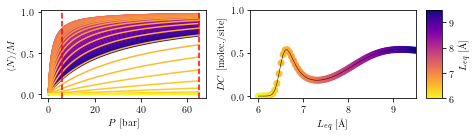

In [13]:
Lspace1 = np.linspace(9.5,6,77)
l1 = compute_all_isos_fcn_Leq(Lspace1, method=compute_Static_isotherm)

Running on N CPUs: 11


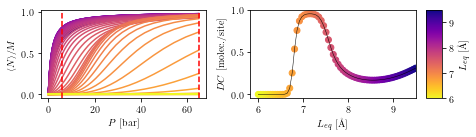

In [11]:
Lspace2 = np.linspace(9.5,6,66)
l2 = compute_all_isos_fcn_Leq(Lspace2, method=compute_Rotate_isotherm)

Running on N CPUs: 11


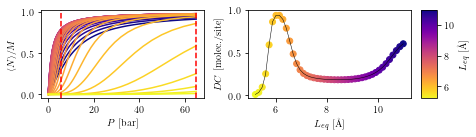

In [10]:
Lspace3 = np.linspace(11,5.2,44)
l3 = compute_all_isos_fcn_Leq(Lspace3, kspring=10000, method=compute_RotateVibrate_isotherm)

Running on N CPUs: 11


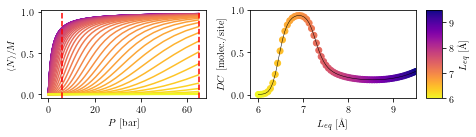

In [18]:
Lspace4 = np.linspace(9.5,6,66)
l4 = compute_all_isos_fcn_Leq(Lspace4, kspring=50000, method=compute_RotateVibrate_isotherm)

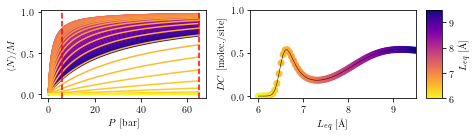

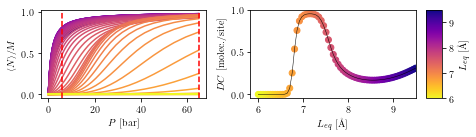

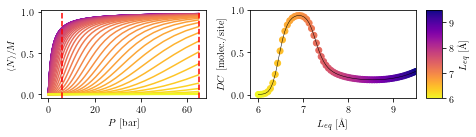

In [19]:
plotIso(l1,special=Lspace1,speciallabel=r"$L_{eq}\textrm{ [\AA]}$",savename="staticDC.pdf")
plotIso(l2,special=Lspace2,speciallabel=r"$L_{eq}\textrm{ [\AA]}$",savename="rotDC.pdf")
plotIso(l4,special=Lspace4,speciallabel=r"$L_{eq}\textrm{ [\AA]}$",savename="rotvibDC.pdf")

#################################################################
# Second Figure: Adsorption enthalpy for S and R slit pores
#################################################################

In [13]:
# Isotherms for computing isosteric heat of rotating slit pore
PSlist = np.logspace(3,7.4,1000)
P296S,N296S,DC296S = compute_Static_isotherm(0,6.7,T=296,Plist=PSlist)
P297S,N297S,DC297S = compute_Static_isotherm(0,6.7,T=297,Plist=PSlist)
P298S,N298S,DC298S = compute_Static_isotherm(0,6.7,T=298,Plist=PSlist)
P299S,N299S,DC299S = compute_Static_isotherm(0,6.7,T=299,Plist=PSlist)
P300S,N300S,DC300S = compute_Static_isotherm(0,6.7,T=300,Plist=PSlist)

# Isotherms for compute isosteric heat of static slit pore
P296,N296,DC296 = compute_Rotate_isotherm(0,7.2,T=296,Plist=PSlist)
P297,N297,DC297 = compute_Rotate_isotherm(0,7.2,T=297,Plist=PSlist)
P298,N298,DC298 = compute_Rotate_isotherm(0,7.2,T=298,Plist=PSlist)
P299,N299,DC299 = compute_Rotate_isotherm(0,7.2,T=299,Plist=PSlist)
P300,N300,DC300 = compute_Rotate_isotherm(0,7.2,T=300,Plist=PSlist)

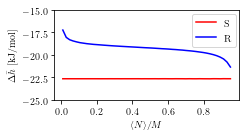

In [14]:
allrawdata = [(P296,N296),(P297,N297),(P298,N298),(P299,N299),(P300,N300)]
allrawdataS = [(P296S,N296S),(P297S,N297S),(P298S,N298S),(P299S,N299S),(P300S,N300S)]

N_interpolate = np.linspace(0.01,0.95,50)

interpolatedPs= np.array([np.array(np.interp(N_interpolate, N_data, P_data))\
                  for P_data,N_data in allrawdata]).T
interpolatedPsS= np.array([np.array(np.interp(N_interpolate, N_data, P_data))\
                  for P_data,N_data in allrawdataS]).T

interpolatedlogPs = np.log(interpolatedPs/10135)
interpolatedlogPsS = np.log(interpolatedPsS/10135)

oneoverT = np.array([1/296,1/297,1/298,1/299,1/300]) 
clausiusclapeyron = np.gradient(interpolatedlogPs,oneoverT,axis=1)
clausiusclapeyronS = np.gradient(interpolatedlogPsS,oneoverT,axis=1)

qst = 8.314114*clausiusclapeyron + 8.314114*298
qstS = 8.314114*clausiusclapeyronS + 8.314114*298

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,1.8),constrained_layout=True)
ax.plot(N_interpolate,qstS[:,2]/1000,c='red',label=r'$\textrm{S}$')
ax.plot(N_interpolate,qst[:,2]/1000,c='blue',label=r'$\textrm{R}$')
ax.set_xlabel(r"$\langle N \rangle / M$")
ax.set_ylabel(r"$\Delta \bar{h} \textrm{ [kJ/mol]}$")
ax.legend(loc='upper right', bbox_to_anchor=(1.01,1.01))
ax.set_ylim((-25,-15))
plt.savefig('deltaH.pdf',transparent=True)
plt.show()


#################################################################
# Third Figure: Volumetric DCs
#################################################################

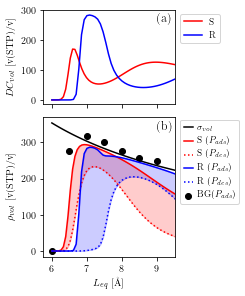

In [22]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(3.3,4),
                       gridspec_kw={'height_ratios': [2, 3]},
                       sharex=True,
                      constrained_layout=True)

volfactor = 8.31441*273.15/(101325*4.19**2*6.02*10**23/10**30)

# last entry (dat[0][-1]) is 65 bar and dat[1][-1] is loading at 65 bar
# 72nd entry (dat[0][4*8]) is 5.9 bar and dat[1][4*8] is loading at 5.9 bar)
#print(l1[0][0][4*18])
#print(l2[0][0][4*18])

static_DC = np.array([dat[2] for dat in l1])*volfactor/Lspace1
ax[0].plot(Lspace1,static_DC,label=r'$\textrm{S}$',c='red')

rot_DC = np.array([dat[2] for dat in l2])*volfactor/Lspace2
ax[0].plot(Lspace2,rot_DC,label=r'$\textrm{R}$',c='blue')

rhosat = np.array([1 for dat in l2])*volfactor/Lspace2
ax[1].plot(Lspace2,rhosat,label=r'$\sigma_{vol}$',c='black',linestyle='-')
# ax[1].plot([],[],label=" ",c="w")

static_ads = np.array([dat[1][-1] for dat in l1])*volfactor/Lspace1
ax[1].plot(Lspace1, static_ads,
        label=r'$\textrm{S }(P_{ads})$',c='red')
static_des = np.array([dat[1][4*18] for dat in l1])*volfactor/Lspace1
ax[1].plot(Lspace1, static_des,
        label=r'$\textrm{S }(P_{des})$',c='red', linestyle=':')
ax[1].fill_between(Lspace1,static_ads,static_des,color='red',alpha=0.2)

rot_ads = np.array([dat[1][-1] for dat in l2])*volfactor/Lspace2
ax[1].plot(Lspace2,rot_ads,
        label=r'$\textrm{R }(P_{ads})$',c='blue')
rot_des = np.array([dat[1][4*18] for dat in l2])*volfactor/Lspace2
ax[1].plot(Lspace2,rot_des,
        label=r'$\textrm{R }(P_{des})$',c='blue',linestyle=':')
ax[1].fill_between(Lspace2,rot_ads,rot_des,color='blue',alpha=0.2)

spacingXrot0P65bar = pd.read_csv('spacingXrot0P65bar.txt',delimiter=r"\s+")
spacingXrot0P65bar.sort_values(by="#framework",inplace=True)
spacing = [float(re.search('spacing(.*)rot', s).group(1)) for s in spacingXrot0P65bar['#framework']]
ax[1].scatter(spacing,spacingXrot0P65bar["avg_load[cm^3(STP)/cm^3]"],marker='o',c='black',label=r'$\textrm{BG}(P_{ads})$')

ax[0].legend(loc='upper left',prop={'size':9},bbox_to_anchor=(1.01,1.01))
ax[1].legend(loc='upper left',prop={'size':9},bbox_to_anchor=(1.01,1.01),ncol=1,
             handletextpad=0.4,handlelength=1.,columnspacing=0.5)
ax[0].set_ylabel(r"$DC_{vol}\textrm{ [v(STP)/v}]$")
ax[1].set_ylabel(r"$\rho_{vol}\textrm{ [v(STP)/v}]$")
ax[0].set_ylim((None,300))

ax[1].set_xlabel(r"$L_{eq}\textrm{ [\AA]}$")
ax[1].set_xlim((None,9.5))

ax[0].text(9,0.87*ax[0].get_ylim()[1],r'$\textrm{(a)}$',size='large')
ax[1].text(9,0.9*ax[1].get_ylim()[1],r'$\textrm{(b)}$',size='large')

#plt.tight_layout(pad=0.2)
plt.savefig('DCvol_allModelsVsLeq.pdf',transparent=True)
plt.show()

#################################################################
# SI Figure: Comparing EF parameters
#################################################################

Adsorption properties:
eps: 734.9863196085439
sig: 3.58
ds: 0.382
Nmax: 4
rmin, Umin (min possible binding U): 3.5800009571997156 -54262.4978764777
Slit pore properties:
L: 7.160001914399431
Framework properties:
params: [10000, 0.2617993877991494, 0.2617993877991494, 100000]
Computing all Q(N) up to Nmax...
Computed Q0 in 0.4s
Integral, uncertainty, Q: (2625788.1227601133, 0.01858404415656878) 2625788.1227601133
Computed Q1 in 0.5s
Integral, uncertainty, Q: (1357824844.7036388, 0.40376407525036484) 5974429316.696012
Computed Q2 in 0.5s
Integral, uncertainty, Q: (2620749651435.482, 2708.199184834957) 19026642469421.6
Computed Q3 in 0.6s
Integral, uncertainty, Q: (9847822648640502.0, 4572336.973672986) 5.242980778136205e+16
Computed Q4 in 0.6s
Integral, uncertainty, Q: (5.572432309408176e+19, 32896287603.629395) 8.158598144204512e+19
>Theta of well minima (deg): 26.049480708575246
DC: 0.7554587376697776
>Theta of well minima (deg): 26.049480708575246
Adsorption properties:
eps: 734.9863

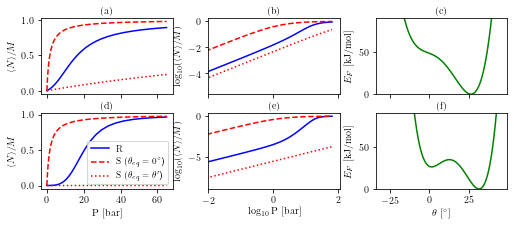

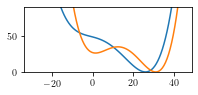

In [24]:
# Comparing adsorption performance of several different 
# rotating slit pore parameter sets

paramlist=[[10000,np.pi/12,np.pi/12,100000],
           [20000,np.pi/6,np.pi/12,50000]]
EFR_summary = []

fig, ax = plt.subplots(nrows=len(paramlist),ncols=3,figsize=(7,1.5*len(paramlist)),sharex='col')

for i in range(len(paramlist)):
    params = paramlist[i]
    
    model = RotatingSlitPore(EFparams={'name':'DoubleWellRotate','params':params})
    mintheta_hi = model.efinstance.compute_minima_hi()
    print(">Theta of well minima (deg):", mintheta_hi*360/(2*np.pi))

    # Data to plot
    Plist = np.logspace(2,6.812913,100)
    isolists = []
    
    # Compute flexible isotherm
    P,N,DC = model.computeIso(Plist)
    isolists.append((P,N,DC,{'label':r"$\textrm{R}$",'c':'blue','linestyle':"-"}))
    print("DC:",DC)
    
    # Compute rigid isotherms at theta = 0 and theta of global EF minimum
    model = RotatingSlitPore(EFparams={'name':'DoubleWellStatic','params':params},
                             verbose=False)
    mintheta_hi = model.efinstance.compute_minima_hi()
    print(">Theta of well minima (deg):", mintheta_hi*360/(2*np.pi))
    
    model.computeAllQ(verbose=False,**{'theta':0})
    P,N,DC = model.computeIso(Plist)
    isolists.append((P,N,DC,{'label':r"$\textrm{S } (\theta_{eq}=0^{\circ}$)",'c':"red",'linestyle':"--"}))

    model.computeAllQ(verbose=False,**{'theta':mintheta_hi})
    P,N,DC = model.computeIso(Plist)
    #isolists.append((P,N,DC,r"$\theta=%.1f^{\circ}$"%(mintheta_hi*360/(2*np.pi)),"red",":"))
    isolists.append((P,N,DC,{'label':r"$\textrm{S } (\theta_{eq}=\theta'$)",'c':"red",'linestyle':":"}))

    if len(paramlist)>1:
        ax0 = ax[i,0]
        ax1 = ax[i,1]
        ax2 = ax[i,2]
    else:
        ax0 = ax[0]
        ax1 = ax[1]
        ax2 = ax[2]
        

    for dat in isolists:
        ax0.plot(dat[0]/100000,dat[1],**dat[3])
        ax1.plot(np.log10(dat[0]/100000),np.log10(dat[1]),**dat[3])

    ax0.set_ylabel(r"$\langle N \rangle/M$")
    ax0.text(0.5,1.05, r"$(\textrm{%s})$"%chr(97+i*3), size=10, ha="center", 
             transform=ax0.transAxes)

    defaultxlim = ax1.get_xlim()
    ax1.set_xlim((-2,defaultxlim[1]))
    ax1.set_ylabel(r"$\log_{10}(\langle N \rangle/M)$")
    ax1.text(0.5,1.05, r"$(\textrm{%s})$"%chr(97+i*3+1), size=10, ha="center", 
             transform=ax1.transAxes)

    thetalist = np.linspace(-30*2*np.pi/360,45*2*np.pi/360,100)
    thetaplotlist = np.linspace(-30,45,100)

    EFlist=np.array([model.computeEF(theta)/1e3 for theta in thetalist])
    EFGlist=np.array([model.computeEFG(model.L/2,theta,model.L)/1e3 for theta in thetalist])
    EFpEFGlist = EFlist+EFGlist

    minE=np.min(EFlist)
    ax2.plot(thetaplotlist,EFlist-minE,label=r"$E_F\left( \theta \right)$",c='green')
    ax2.set_ylim((0,90))
    ax2.set_ylabel(r"$E_F~\textrm{[kJ/mol]}$")
    ax2.text(0.5,1.05, r"$(\textrm{%s})$"%chr(97+i*3+2), size=10, ha="center", 
         transform=ax2.transAxes)
    EFR_summary.append([thetaplotlist,EFlist-minE])
    
    if i == len(paramlist)-1:
        ax0.legend(loc='best',prop={'size':9})
        ax0.set_xlabel(r"$\textrm{P [bar]}$")
        ax1.set_xlabel(r"$\log_{10}\textrm{P [bar]}$")
        ax2.set_xlabel(r"$\theta~[^{\circ}]$")
        
plt.tight_layout(pad=0.2)
plt.savefig('rotSP.pdf',transparent=True)
plt.show()

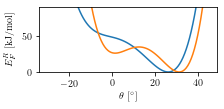

In [30]:
# NEW: add Ef^R profiles for main text
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,1.4),
                      constrained_layout=True)

ax.plot(EFR_summary[0][0],EFR_summary[0][1])
ax.plot(EFR_summary[1][0],EFR_summary[1][1])
ax.set_ylim((0,90))
ax.set_ylabel(r"$E_F^R~\textrm{[kJ/mol]}$")
ax.set_xlabel(r"$\theta~[^{\circ}]$")
plt.savefig("EFRexample.pdf")
plt.show()

#################################################################
# Additional: Comparison of S, R, and R+V DC's
#################################################################

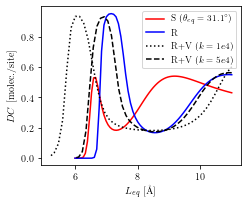

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,2.7),sharex=True)

ax.plot(Lspace1,[dat[2] for dat in l1],label=r'$\textrm{S }(\theta_{eq}=31.1^{\circ})$',c='red')
ax.plot(Lspace2,[dat[2] for dat in l2],label=r'$\textrm{R }$',c='blue')
ax.plot(Lspace3,[dat[2] for dat in l3],label=r'$\textrm{R+V }(k=1e4)$',c='black',linestyle=':')
ax.plot(Lspace4,[dat[2] for dat in l4],label=r'$\textrm{R+V }(k=5e4)$',c='black',linestyle='--')
#ax.legend(bbox_to_anchor=(-.07,1.02,1.2,0.2),prop={'size':9},ncol=2)
ax.legend(loc='best',prop={'size':9})
ax.set_xlabel(r"$L_{eq}\textrm{ [\AA]}$")
ax.set_ylabel(r"$DC\textrm{ [molec./site]}$")

# ax[1].plot(Lspace1,[dat[2] for dat in l1]/Lspace1,label='Static',c='blue')
# ax[1].plot(Lspace2,[dat[2] for dat in l2]/Lspace2,label='Rot.',c='red')
# ax[1].plot(Lspace3,[dat[2] for dat in l3]/Lspace3,label='Rot.+Vib.',c='green')
plt.tight_layout(pad=0.2)
plt.savefig('DCallModelsVsLeq.pdf',transparent=True)
plt.show()

#################################################################
# Additional Figure: S pore energies and isotherms
#################################################################

Adsorption properties:
eps: 734.9863196085439
sig: 3.58
ds: 0.382
Nmax: 1
rmin, Umin (min possible binding U): 3.5800009571997156 -54262.4978764777
Slit pore properties:
L: 7.160001914399431
Framework properties:
params: [20000, 0.5235987755982988, 0.2617993877991494, 50000]
Computing all Q(N) up to Nmax...
Computed Q0 in 0.0s
Integral, uncertainty, Q: (23054.506140917598, 1.110000874687822e-07) 1.0
Computed Q1 in 0.0s
Integral, uncertainty, Q: (23054.506140917598, 1.110000874687822e-07) 25359.95675500936


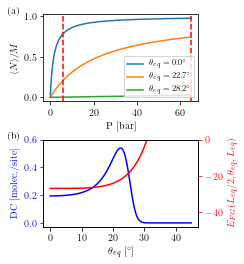

In [18]:
####################################################
# Static pore DC's as a function of theta
params = [20000,np.pi/6,np.pi/12,50000]
model = RotatingSlitPore(EFparams={'name':'DoubleWellStatic',
                                   'params':params},
                         verbose=True,
                         Nmax=1)
thetalist = np.linspace(0,45*2*np.pi/360,100)
allDCs=[]
allEFGs=[]
allNs = []
Plist = np.logspace(3,6.812913,100)

for theta in thetalist:
    model.computeAllQ(verbose=False,**{'theta':theta})
    P,N,DC = model.computeIso(Plist)
    allDCs.append(DC)
    allNs.append(N)
    allEFGs.append(model.computeEFG(model.L/2,theta,model.L)/1000)
    
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(3.3,3.5))
ax[1].plot(thetalist*360/(2*np.pi),allDCs,c="blue")
ax[1].set_xlabel(r"$\theta_{eq}~[^{\circ}]$")
ax[1].set_ylabel(r"$\textrm{DC [molec./site]}$")
ax[1].set_yticks([0,0.2,0.4,0.6])
#ax[1].spines['left'].set_color(DEFCOLS[0])
ax[1].yaxis.label.set_color("blue")
ax[1].tick_params(axis='y', colors="blue")
ax[1].text(-0.19,1, r"$(\textrm{b})$", size=10, ha="center", 
         transform=ax[1].transAxes)

axtwin = ax[1].twinx()
axtwin.plot(thetalist*360/(2*np.pi),allEFGs,c="red")
axtwin.set_ylim((None,0))
axtwin.set_ylabel(r"$E_{FG}(L_{eq}/2,\theta_{eq},L_{eq})$")
#axtwin.spines['right'].set_color(DEFCOLS[1])
axtwin.yaxis.label.set_color("red")
axtwin.tick_params(axis='y', colors="red")

ind = 0
ax[0].plot(Plist/1e5,allNs[ind],label=r"$\theta_{eq}=%0.1f^{\circ}$"%(thetalist[ind]*360/(2*np.pi)))
ind = 50
ax[0].plot(Plist/1e5,allNs[ind],label=r"$\theta_{eq}=%0.1f^{\circ}$"%(thetalist[ind]*360/(2*np.pi)))
ind = 62
ax[0].plot(Plist/1e5,allNs[ind],label=r"$\theta_{eq}=%0.1f^{\circ}$"%(thetalist[ind]*360/(2*np.pi)))

defaultylim = ax[0].get_ylim()
ax[0].plot([5.8,5.8], defaultylim, c="red",linestyle='--')
ax[0].plot([65,65], defaultylim, c="red",linestyle='--')
ax[0].set_ylim(defaultylim)

ax[0].set_xlabel(r"$\textrm{P [bar]}$")
ax[0].set_ylabel(r"$\langle N \rangle / M$")
ax[0].legend(loc='lower right',prop={'size':8})
ax[0].text(-0.19,1, r"$(\textrm{a})$", size=10, ha="center", 
         transform=ax[0].transAxes)

plt.tight_layout(pad=0.1)
plt.savefig('statictheta.pdf',transparent=True)
plt.show()

Adsorption properties:
eps: 734.9863196085439
sig: 3.58
ds: 0.382
Nmax: 1
rmin, Umin (min possible binding U): 3.5800009571997156 -54262.4978764777
Slit pore properties:
L: 7.160001914399431
Framework properties:
params: [20000, 0.5235987755982988, 0.2617993877991494, 50000]
Computing all Q(N) up to Nmax...
Computed Q0 in 0.0s
Integral, uncertainty, Q: (23054.506140917598, 1.110000874687822e-07) 1.0
Computed Q1 in 0.0s
Integral, uncertainty, Q: (23054.506140917598, 1.110000874687822e-07) 25359.95675500936
[0.20226821312079202, 0.5456620237050244, 0.024817328053538715, 0.9530846531208852] [0 1 2 3 4]


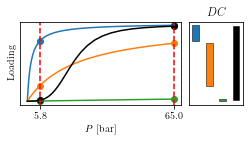

In [19]:
####################################################
# Static pore DC's as a function of theta
params = [20000,np.pi/6,np.pi/12,50000]
model = RotatingSlitPore(EFparams={'name':'DoubleWellStatic',
                                   'params':params},
                         verbose=True,
                         Nmax=1)
thetalist = np.linspace(0,45*2*np.pi/360,100)
allDCs=[]
allEFGs=[]
allNs = []
Plist = np.logspace(2,6.812913,100)

for theta in thetalist:
    model.computeAllQ(verbose=False,**{'theta':theta})
    P,N,DC = model.computeIso(Plist)
    allDCs.append(DC)
    allNs.append(N)
    allEFGs.append(model.computeEFG(model.L/2,theta,model.L)/1000)
    
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(3.3,1.8),gridspec_kw={'width_ratios':[3,1]})

hist = []
heights = []

ax = axs[0]
# too strong binding
ind = 0
ax.plot(Plist/1e5,allNs[ind])#,label=r"$\theta_{eq}=%0.1f^{\circ}$"%(thetalist[ind]*360/(2*np.pi)))
DC = np.take(allNs[ind],(77,-1))
ax.scatter(np.take(Plist,(77,-1))/1e5,DC,color=DEFAULT_COLORS[0])
hist.append(DC[1]-DC[0])
heights.append(DC[0])

# optimal binding
ind = 50
ax.plot(Plist/1e5,allNs[ind])#,label=r"$\theta_{eq}=%0.1f^{\circ}$"%(thetalist[ind]*360/(2*np.pi)))
DC = np.take(allNs[ind],(77,-1))
ax.scatter(np.take(Plist,(77,-1))/1e5,DC,color=DEFAULT_COLORS[1])
hist.append(DC[1]-DC[0])
heights.append(DC[0])

# too weak binding
ind = 62
ax.plot(Plist/1e5,allNs[ind])#,label=r"$\theta_{eq}=%0.1f^{\circ}$"%(thetalist[ind]*360/(2*np.pi)))
DC = np.take(allNs[ind],(77,-1))
ax.scatter(np.take(Plist,(77,-1))/1e5,DC,color=DEFAULT_COLORS[2])
hist.append(DC[1]-DC[0])
heights.append(DC[0])

# flexible
ax.plot(isolists[0][0]/1e5,isolists[0][1],c='black')
DC = np.take(isolists[0][1],(77,-1))
ax.scatter(np.take(isolists[0][0],(77,-1))/1e5,DC,color="black")
hist.append(DC[1]-DC[0])
heights.append(DC[0])

defaultylim = ax.get_ylim()
ax.plot([5.8,5.8], defaultylim, c="red",linestyle='--')
ax.plot([65,65], defaultylim, c="red",linestyle='--')
ax.set_ylim(defaultylim)

ax.set_xlabel(r"$P\textrm{ [bar]}$")
ax.set_ylabel(r"$\textrm{Loading}$")
#ax.legend(loc='lower right',prop={'size':8})
# ax.text(-0.19,1, r"$(\textrm{a})$", size=10, ha="center", 
#          transform=ax.transAxes)

ax.set_yticks([])
ax.set_xticks([5.8,65])
origylim=ax.get_ylim()

ax = axs[1]

bin_edges = np.arange(len(hist)+1)
print(hist,bin_edges)
# ax.hist(bin_edges[0],bin_edges[0:2],weights=hist[0],color=DEFAULT_COLORS[0],edgecolor='black')
# ax.hist(bin_edges[1],bin_edges[1:3],weights=hist[1],color=DEFAULT_COLORS[1],edgecolor='black')
# ax.hist(bin_edges[2],bin_edges[2:4],weights=hist[2],color=DEFAULT_COLORS[2],edgecolor='black')
# ax.hist(bin_edges[3],bin_edges[3:5],weights=hist[3],color="black",edgecolor='black')
ax.bar(bin_edges[0:-1],height=hist,width=0.5,bottom=heights,edgecolor='black',linewidth=0.5,
       color=[DEFAULT_COLORS[0],DEFAULT_COLORS[1],DEFAULT_COLORS[2],"black"])


ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(origylim)
ax.set_title(r'$DC$')
ax.set_xlim(-0.5,3.5)

plt.tight_layout(pad=0.1)
plt.savefig('DCexample.pdf',transparent=True)
plt.show()